# For Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import os
os.chdir("drive/My Drive/Slikovna biometrija/Assignment3")
!ls

config.json			    README
config_recognition.json		    resnet.ipynb
config_recognition_mask-r-cnn.json  resnet_val_edge.png
data				    resnet_val_equalization.png
detectors			    resnet_val.png
feature_extractors		    resnet_val_sharpening.png
metrics				    run_evaluation.py
preprocessing			    run_recognition_evaluation.py
Ranks.png


In [3]:
os.getcwd()

'/content/drive/My Drive/Slikovna biometrija/Assignment3'

# Ear based identification using ResNet50

## Imports, constants and helper functions

In [1]:
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
from data.AWEDataset import AWETestSet, AWETrainSet, AWEValSet
from feature_extractors.your_super_extractor.CNN_detector import CNNEarDetector
import cv2
import os
import matplotlib.pyplot as plt
from preprocessing.preprocess import HistogramEqualization, EdgeEnhancement, ImageSharpening

In [2]:
torch.cuda.is_available()

True

In [3]:
INPUT_SIZE = 224
BATCH_SIZE = 8
# Number of classes in train set
NUM_CLASSES = 100

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_equalization = {
    'train': transforms.Compose([
        HistogramEqualization(),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        HistogramEqualization(),
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_edge = {
    'train': transforms.Compose([
        EdgeEnhancement(),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        EdgeEnhancement(),
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_transforms_sharpening = {
    'train': transforms.Compose([
        ImageSharpening(),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        ImageSharpening(),
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

## Perfectly detected ears

### Data loading inspection

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), None)
train_data[0]

(<PIL.Image.Image image mode=RGB size=53x78 at 0x7F5E1D0759D0>, tensor(99))

tensor(99)


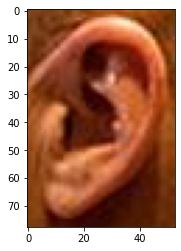

In [ ]:
image, label = train_data[0]
plt.imshow(image)
print(label)

### Without preprocessing

#### Load train and val data

In [7]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms["train"])
train_data[0]

(tensor([[[ 0.3994,  0.3994,  0.3994,  ...,  1.9407,  1.9407,  1.9407],
          [ 0.3994,  0.3994,  0.3994,  ...,  1.9407,  1.9407,  1.9407],
          [ 0.3994,  0.3994,  0.3994,  ...,  1.9407,  1.9407,  1.9407],
          ...,
          [-0.0801, -0.0801, -0.0801,  ..., -0.2342, -0.2342, -0.2342],
          [-0.0801, -0.0801, -0.0801,  ..., -0.2342, -0.2342, -0.2342],
          [-0.0801, -0.0801, -0.0801,  ..., -0.2342, -0.2342, -0.2342]],
 
         [[-1.0553, -1.0553, -1.0553,  ...,  0.5028,  0.5028,  0.5028],
          [-1.0553, -1.0553, -1.0553,  ...,  0.5028,  0.5028,  0.5028],
          [-1.0553, -1.0553, -1.0553,  ...,  0.5028,  0.5028,  0.5028],
          ...,
          [-1.2654, -1.2654, -1.2654,  ..., -1.3880, -1.3880, -1.3880],
          [-1.2654, -1.2654, -1.2654,  ..., -1.3880, -1.3880, -1.3880],
          [-1.2654, -1.2654, -1.2654,  ..., -1.3880, -1.3880, -1.3880]],
 
         [[-1.1421, -1.1421, -1.1421,  ..., -0.3753, -0.3753, -0.3753],
          [-1.1421, -1.1421,

In [8]:
val_data = AWEValSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms["val"])
val_data[0]

(tensor([[[-0.5938, -0.5938, -0.5253,  ...,  0.3309,  0.3652,  0.3652],
          [-0.5938, -0.5938, -0.5253,  ...,  0.2967,  0.3309,  0.3309],
          [-0.5938, -0.5938, -0.5253,  ...,  0.2624,  0.2967,  0.2967],
          ...,
          [-1.9809, -1.9809, -1.9638,  ...,  0.9474,  0.9646,  0.9646],
          [-1.9809, -1.9809, -1.9638,  ...,  0.9474,  0.9646,  0.9646],
          [-1.9809, -1.9809, -1.9638,  ...,  0.9474,  0.9646,  0.9646]],
 
         [[-0.9678, -0.9678, -0.9678,  ..., -0.2675, -0.2150, -0.2150],
          [-0.9678, -0.9678, -0.9678,  ..., -0.3025, -0.2500, -0.2500],
          [-0.9678, -0.9678, -0.9678,  ..., -0.3375, -0.2850, -0.2850],
          ...,
          [-1.8957, -1.8957, -1.8782,  ...,  0.3803,  0.3803,  0.3803],
          [-1.8957, -1.8957, -1.8782,  ...,  0.3803,  0.3803,  0.3803],
          [-1.8957, -1.8957, -1.8782,  ...,  0.3803,  0.3803,  0.3803]],
 
         [[-0.9504, -0.9504, -0.9678,  ..., -0.3753, -0.3230, -0.3230],
          [-0.9330, -0.9330,

In [9]:
# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
                   'val': torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)}

#### Train the model

In [10]:
model = CNNEarDetector(model="resnet", num_classes=train_data.get_num_classes(), extract_features=False)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 200
hist = model.train(dataloaders_dict, criterion, num_epochs=num_epochs)

Training model on GPUs
Epoch 0/199
----------
train Loss: 4.6647 Acc: 0.0072
val Loss: 4.6450 Acc: 0.0060

Epoch 1/199
----------
train Loss: 4.6494 Acc: 0.0024
val Loss: 4.6362 Acc: 0.0090

Epoch 2/199
----------
train Loss: 4.6173 Acc: 0.0096
val Loss: 4.6160 Acc: 0.0060

Epoch 3/199
----------
train Loss: 4.5997 Acc: 0.0048
val Loss: 4.6129 Acc: 0.0090

Epoch 4/199
----------
train Loss: 4.5958 Acc: 0.0096
val Loss: 4.6096 Acc: 0.0209

Epoch 5/199
----------
train Loss: 4.5895 Acc: 0.0120
val Loss: 4.6039 Acc: 0.0209

Epoch 6/199
----------
train Loss: 4.5689 Acc: 0.0169
val Loss: 4.6081 Acc: 0.0119

Epoch 7/199
----------
train Loss: 4.5492 Acc: 0.0241
val Loss: 4.5909 Acc: 0.0209

Epoch 8/199
----------
train Loss: 4.5369 Acc: 0.0361
val Loss: 4.5953 Acc: 0.0209

Epoch 9/199
----------
train Loss: 4.5305 Acc: 0.0313
val Loss: 4.5795 Acc: 0.0239

Epoch 10/199
----------
train Loss: 4.5168 Acc: 0.0313
val Loss: 4.5754 Acc: 0.0269

Epoch 11/199
----------
train Loss: 4.5032 Acc: 0.03

In [11]:
model.save(os.getcwd(), "trained_resnet")

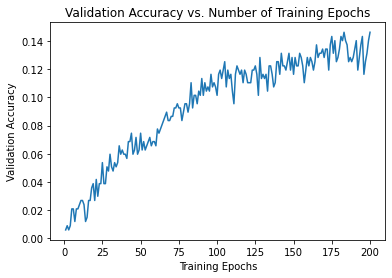

In [12]:
val_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), val_hist)
plt.savefig(os.getcwd()+"/resnet_val.png")
plt.show()

### Histogram equalization

#### Inspect data loading

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), transforms.Compose([HistogramEqualization()]))
train_data[0]

In [ ]:
image, label = train_data[0]
plt.imshow(image)
print(label)

#### Load train and val data

In [7]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_equalization["train"])
val_data = AWEValSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_equalization["val"])

# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
                   'val': torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)}

#### Train the model

In [8]:
model = CNNEarDetector(model="resnet", num_classes=train_data.get_num_classes(), extract_features=False)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 200
hist = model.train(dataloaders_dict, criterion, num_epochs=num_epochs)

Training model on GPUs
Epoch 0/199
----------
train Loss: 4.6803 Acc: 0.0072
val Loss: 4.6367 Acc: 0.0179

Epoch 1/199
----------
train Loss: 4.6443 Acc: 0.0072
val Loss: 4.6273 Acc: 0.0090

Epoch 2/199
----------
train Loss: 4.6249 Acc: 0.0096
val Loss: 4.6186 Acc: 0.0119

Epoch 3/199
----------
train Loss: 4.6177 Acc: 0.0096
val Loss: 4.6008 Acc: 0.0119

Epoch 4/199
----------
train Loss: 4.5880 Acc: 0.0120
val Loss: 4.5905 Acc: 0.0179

Epoch 5/199
----------
train Loss: 4.5755 Acc: 0.0193
val Loss: 4.5816 Acc: 0.0119

Epoch 6/199
----------
train Loss: 4.5705 Acc: 0.0096
val Loss: 4.5764 Acc: 0.0239

Epoch 7/199
----------
train Loss: 4.5632 Acc: 0.0241
val Loss: 4.5710 Acc: 0.0299

Epoch 8/199
----------
train Loss: 4.5461 Acc: 0.0145
val Loss: 4.5692 Acc: 0.0358

Epoch 9/199
----------
train Loss: 4.5332 Acc: 0.0265
val Loss: 4.5577 Acc: 0.0537

Epoch 10/199
----------
train Loss: 4.5221 Acc: 0.0434
val Loss: 4.5612 Acc: 0.0269

Epoch 11/199
----------
train Loss: 4.5112 Acc: 0.04

In [9]:
model.save(os.getcwd(), "trained_resnet_equalization")

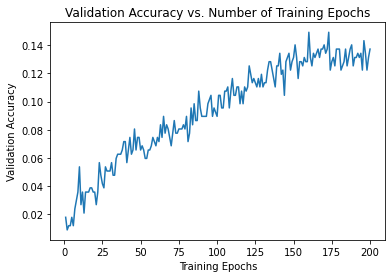

In [10]:
val_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), val_hist)
plt.savefig(os.getcwd()+"/resnet_val_equalization.png")
plt.show()

### Edge enhancement

#### Inspect the data loading

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), transforms.Compose([EdgeEnhancement()]))
train_data[0]

(<PIL.Image.Image image mode=RGB size=53x78 at 0x7F979498F1D0>, tensor(99))

tensor(99)


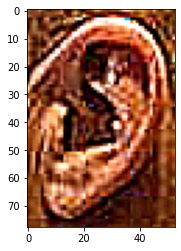

In [ ]:
image, label = train_data[0]
plt.imshow(image)
print(label)

#### Load train and val data

In [7]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_edge["train"])
val_data = AWEValSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_edge["val"])

# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2),
                   'val': torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)}

#### Train the model

In [8]:
model = CNNEarDetector(model="resnet", num_classes=train_data.get_num_classes(), extract_features=False)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 200
hist = model.train(dataloaders_dict, criterion, num_epochs=num_epochs)

Training model on GPUs
Epoch 0/199
----------
train Loss: 4.6479 Acc: 0.0145
val Loss: 4.6570 Acc: 0.0090

Epoch 1/199
----------
train Loss: 4.6349 Acc: 0.0048
val Loss: 4.6343 Acc: 0.0030

Epoch 2/199
----------
train Loss: 4.6166 Acc: 0.0072
val Loss: 4.6396 Acc: 0.0000

Epoch 3/199
----------
train Loss: 4.5920 Acc: 0.0145
val Loss: 4.6220 Acc: 0.0119

Epoch 4/199
----------
train Loss: 4.5792 Acc: 0.0096
val Loss: 4.6120 Acc: 0.0179

Epoch 5/199
----------
train Loss: 4.5647 Acc: 0.0145
val Loss: 4.6152 Acc: 0.0090

Epoch 6/199
----------
train Loss: 4.5314 Acc: 0.0217
val Loss: 4.6068 Acc: 0.0149

Epoch 7/199
----------
train Loss: 4.5285 Acc: 0.0169
val Loss: 4.5992 Acc: 0.0119

Epoch 8/199
----------
train Loss: 4.5228 Acc: 0.0289
val Loss: 4.5921 Acc: 0.0090

Epoch 9/199
----------
train Loss: 4.5142 Acc: 0.0265
val Loss: 4.5959 Acc: 0.0119

Epoch 10/199
----------
train Loss: 4.4829 Acc: 0.0361
val Loss: 4.5827 Acc: 0.0090

Epoch 11/199
----------
train Loss: 4.4845 Acc: 0.04

In [9]:
model.save(os.getcwd(), "trained_resnet_edge")

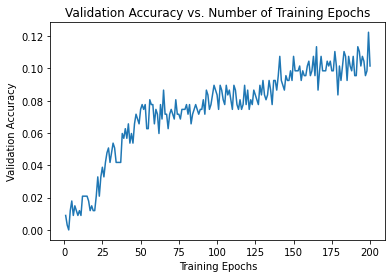

In [10]:
val_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), val_hist)
plt.savefig(os.getcwd()+"/resnet_val_edge.png")
plt.show()

### Image sharpening

#### Inspect the data loading

In [ ]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), transforms.Compose([ImageSharpening()]))
train_data[0]

(<PIL.Image.Image image mode=RGB size=53x78 at 0x7F32A5839A10>, tensor(99))

tensor(99)


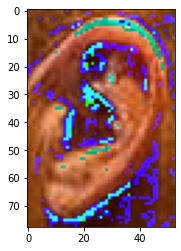

In [ ]:
image, label = train_data[0]
plt.imshow(image)
print(label)

#### Load train and val data

In [4]:
train_data = AWETrainSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_sharpening["train"])
val_data = AWEValSet(os.path.join(os.getcwd(), "data/perfectly_detected_ears"), data_transforms_sharpening["val"])

# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4),
                   'val': torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)}

#### Train the model

In [5]:
model = CNNEarDetector(model="resnet", num_classes=train_data.get_num_classes(), extract_features=False)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
num_epochs = 200
hist = model.train(dataloaders_dict, criterion, num_epochs=num_epochs)

Training model on GPUs
Epoch 0/199
----------
train Loss: 4.6750 Acc: 0.0072
val Loss: 4.6328 Acc: 0.0119

Epoch 1/199
----------
train Loss: 4.6435 Acc: 0.0072
val Loss: 4.6331 Acc: 0.0060

Epoch 2/199
----------
train Loss: 4.6173 Acc: 0.0072
val Loss: 4.6164 Acc: 0.0149

Epoch 3/199
----------
train Loss: 4.6014 Acc: 0.0169
val Loss: 4.6087 Acc: 0.0090

Epoch 4/199
----------
train Loss: 4.6027 Acc: 0.0169
val Loss: 4.6049 Acc: 0.0209

Epoch 5/199
----------
train Loss: 4.5870 Acc: 0.0169
val Loss: 4.5972 Acc: 0.0060

Epoch 6/199
----------
train Loss: 4.5741 Acc: 0.0217
val Loss: 4.5881 Acc: 0.0090

Epoch 7/199
----------
train Loss: 4.5586 Acc: 0.0217
val Loss: 4.5834 Acc: 0.0209

Epoch 8/199
----------
train Loss: 4.5357 Acc: 0.0217
val Loss: 4.5846 Acc: 0.0239

Epoch 9/199
----------
train Loss: 4.5169 Acc: 0.0434
val Loss: 4.5705 Acc: 0.0269

Epoch 10/199
----------
train Loss: 4.5106 Acc: 0.0410
val Loss: 4.5637 Acc: 0.0090

Epoch 11/199
----------
train Loss: 4.4936 Acc: 0.03

In [6]:
model.save(os.getcwd(), "trained_resnet_sharpening")

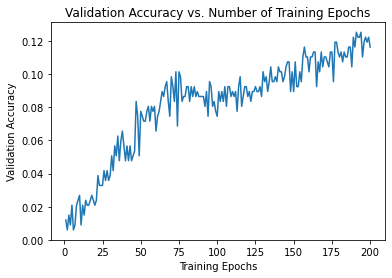

In [7]:
val_hist = [h.cpu().numpy() for h in hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1), val_hist)
plt.savefig(os.getcwd()+"/resnet_val_sharpening.png")
plt.show()